## 1. Изучение и подготовка данных

### 1.1 Описание проекта "Восстановление золота из золотосодержащей руды"

Целью проекта является создание модели предсказания количества извлеченного выборочного драгоценного металла из поступаещего на производство сырья.

Нам предоставлены сырые данные по золотодобывающему производству в виде трех датасетов: исходные данные, обучающие и тестовые. Также нам предоставлена схема и карта всех производственных процессов получения золота из золотосодержащей руды и формулы эффективности обогащения и итоговую метрику sMAPE. Нашей задачей является создать модель для предсказания коэффициента восстановления золота из золотосодержащей руды. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

В ходе работы над проектом будут проделаны следующие шаги:

- изучим предоставленные данные;
- проведем исследовательский аналих и предобработку данных;
- проведем визуальный анализ материалов на всех этапах их обработки для проверки распределния данных и наличия аномалий;
- реализуем функцию расчета итоговой метрики;
- реализуем и проверим несколько моделей на обучающих данных;
- проверим тестовые данные на итоговой модели, опишем результаты;
- подведем итог работы над проектом.

### 1.2 Откройте файлы и изучите их

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.dummy import DummyRegressor 

import warnings
warnings.filterwarnings('ignore')
RS = 17

чтение файлов: инфо, пропуски, дубликаты

In [2]:
df_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv')
df_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv')
df_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv')
        
for i,j in zip((df_full, df_train, df_test), 
               ('ИСХОДНЫЕ ДАННЫЕ',
                'ОБУЧАЮЩАЯ ВЫБОРКА',
                'ТЕСТОВАЯ ВЫБОРКА')):
    print()
    print(' '*15,j)
    print()
    i.info()
    print()
    print(f'Количество пропусков = {i.isna().sum().sum()}')
    print(f'Количество дубликатов = {i.duplicated().sum()}')
    print()
    print('-'*90)


                ИСХОДНЫЕ ДАННЫЕ

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                     

В исходных данных (ИД) и обучающей выборке (ОВ) 87 признаков, в тестовой выборке (ТВ) 53 признака. Исходный датасет содержит обучающую и тестовую выборки со всеми признаками. Часть данных и целевые признаки в тестовой выборке отсутсвуют, т.к.замеряются и/или рассчитываются позже.

### 1.3 Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

Эффективность обогащения рассчитывается по формуле recovery = (C*(F-T)/F*(C-T))*100:
- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
 -T — доля золота в отвальных хвостах после флотации/очистки.

In [3]:
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

recovery_rougher_output = ((C*(F-T))/(F*(C-T)))*100

print(f"{mean_absolute_error(df_train['rougher.output.recovery'], recovery_rougher_output):.2f}")

0.00


Для признака rougher.output.recovery_au было проведено сравнение его табличного значения с расчитанным. Результат вычисления значения абсолютной ошибки между этими показателями стремится к нулю, что означает равенство этих значений, а значит эффективность обогащения рассчитана правильно.

### 1.4 Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся? 

Проверка отсутсвующих признаков в ТВ

In [4]:
diff = df_train.columns.difference(df_test.columns)
print('Отсутсвующие признаки в тестовой выборке:')
list(diff)

Отсутсвующие признаки в тестовой выборке:


['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В ТВ отсутсвуют:

- ***целевые признаки***;
- ***final.output*** (финальные концентраты металлов и их отвальне хвосты);
- ***primary_cleaner.output*** (концентраты металлов и их отвальне хвосты после первичной очистки);
- ***rougher.calculation*** (посчитанные метрики после флотации);
- ***rougher.output*** (концентраты металлов и их отвальне хвосты после флотации);
- ***secondary_cleaner.output*** (концентраты металлов и их отвальне хвосты после вторичной очистки).

Согласно описанию отсутсвующих признаков - это значения метрик, описывающие результаты обработки сырья, т.е. результаты обогащения сырья и получения конечного продукта, а также посчитанные промежуточные метрики. Благодаря этим данным будут видны промежутоные итоги по каждому этапу для корректировки процессов повышения качества конечного продукта и уменьшению отвальных хвостов

### 1.5 Проведите предобработку данных. 

Предобработка сводится к устранению пропусков. Удаление пропусков исключается, т.к. будет потеря большая потеря данных, более 10%. Каждый признак имеет свой масштаб значений, поэтому замена на 0 недопустима, т.к. приведет к искажению масштаба выборки. Допустимым является замена предыдущее значение до пропуска, т.к. будет минимальная разница между смежными значениями и будет нормальное распределение без аномалий.

In [5]:
print(f'Потеря данных при удалении пропусков =  {(df_train.isna().sum().sum()/df_train.shape[0]).round(1)*100} %')

Потеря данных при удалении пропусков =  30.0 %


In [6]:
for i in (df_full, df_train, df_test):
     i.fillna(method='ffill', inplace=True)

# проверка
print(f'Количество пропусков в обучающей выборке = {df_train.isna().sum().sum()}')
print(f'Количество пропусков в тестовой выборке = {df_test.isna().sum().sum()}')

Количество пропусков в обучающей выборке = 0
Количество пропусков в тестовой выборке = 0


### 1.6 Вывод

В ходе предобработки данных были проделаны следующие шаги:
- изучены датасеты, проверены на дубликаты, пропуки;
- проверена и доказана адекватность значения эффективности обогащения по признаку rougher.output.recovery;
- проанализированы обучающие и тестовые выборки;
- выявлено соотношение пропусков в данных, обоснован и применен метод их устранения.

## 2. Анализ данных

### 2.1 Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы. 

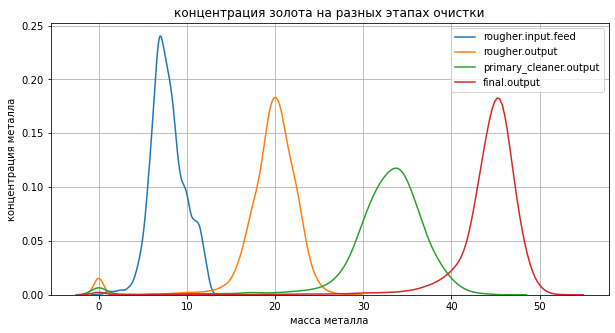

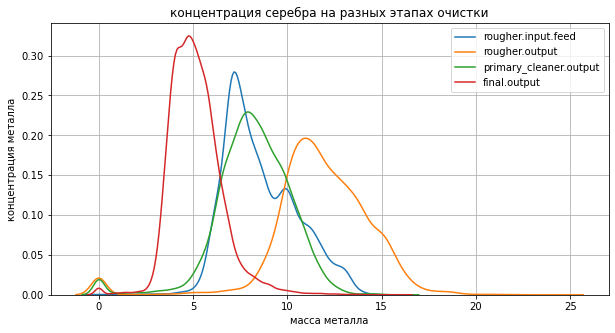

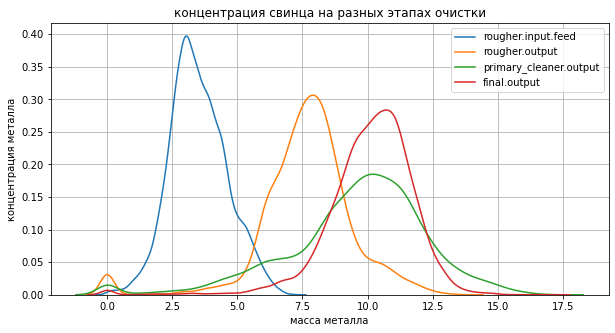

In [7]:
def concentrate_stages_metalls():

    for i,j in zip(('au','ag','pb'),
                   ('золота', 'серебра', 'свинца')):    

        plt.figure(figsize=(10,5))
        
        sns.kdeplot(x=df_train['rougher.input.feed_' + i], label='rougher.input.feed')
        sns.kdeplot(x=df_train['rougher.output.concentrate_' + i], label='rougher.output')
        sns.kdeplot(x=df_train['primary_cleaner.output.concentrate_' + i], label='primary_cleaner.output')
        sns.kdeplot(x=df_train['final.output.concentrate_' + i], label='final.output')

        plt.legend()
        plt.grid()
        plt.title(f'концентрация {j} на разных этапах очистки')
        plt.xlabel('масса металла')
        plt.ylabel('концентрация металла')
        plt.show()
        
concentrate_stages_metalls()

На этапе первичной очистки после флотации:
- концентрация всех металлов падает почти в 2 раза, т.к. этап грубой очистки является самым агрессивным.

На этапе финальной очистки:
- концентрация серебра продолжает уменьшаться;
- концентрация свинца и золота повышаются и становятся чуть выше исходных, что говорит об эффективности технологического процесса.

На графике наблюдаются выбросы в нуле.

Смею предположить, что на оси абсцисс отображена масса взятых проб, т.к. после каждого этапа появляются отвальные хвосты, вследствие появления которых соответственно падает значение массы исходника.

### 2.2 Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной. 

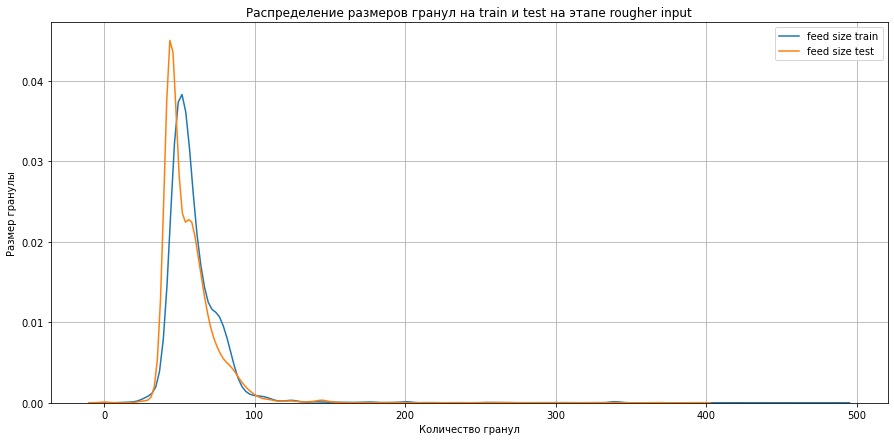

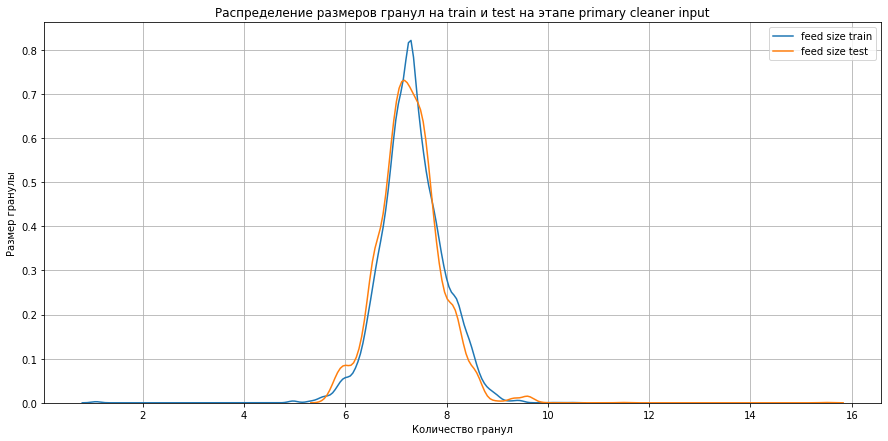

In [8]:
for i,j in zip(('rougher.input.feed_size','primary_cleaner.input.feed_size'),
               ('rougher input','primary cleaner input')): 
    
    plt.figure(figsize=(15,7))

    sns.kdeplot(x=df_train[i], label='feed size train')
    sns.kdeplot(x=df_test[i], label='feed size test')

    plt.legend()
    plt.grid()
    plt.xlabel('Количество гранул')
    plt.ylabel('Размер гранулы')
    plt.title('Распределение размеров гранул на train и test на этапе ' + j);

На графиках распределения достаточно апроксимированы, формы изгибов повторяют друг друга со смещением влево на тестовой выборке на первом графике, на смещение распределений обоих показателей может влиять наличие выбросов

### 2.3 Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

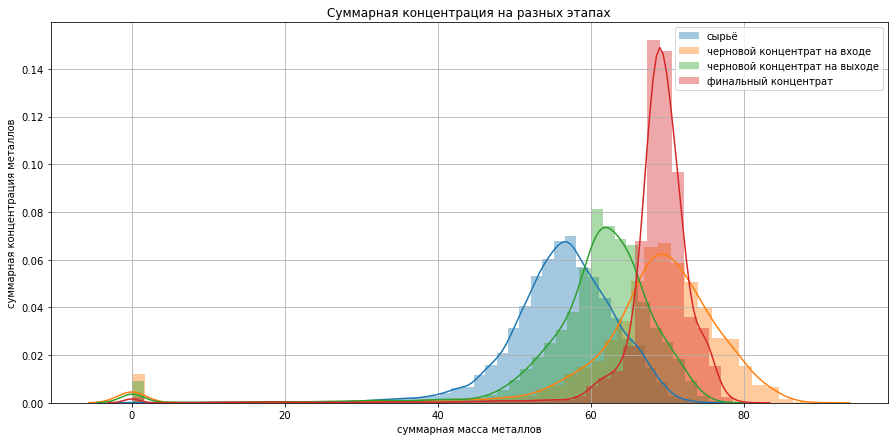

In [9]:
def concentrate_metalls_all_stages():

    plt.figure(figsize=(15,7))

    for i,j in zip(('rougher.input.feed_', 
                    'rougher.output.concentrate_', 
                    'primary_cleaner.output.concentrate_', 
                    'final.output.concentrate_'),
                   
                    ('сырьё',
                     'черновой концентрат на входе',
                     'черновой концентрат на выходе',
                     'финальный концентрат')):

        sns.distplot(df_train[[i + 'au', i + 'ag', i + 'pb', i + 'sol']].sum(axis=1), label=j)

        plt.grid(True)
        plt.legend()
        plt.xlabel('суммарная масса металлов')
        plt.ylabel('суммарная концентрация металлов')
        plt.title('Суммарная концентрация на разных этапах')
        
concentrate_metalls_all_stages()

На графике видно, что на каждом этапе есть выбросы в нуле, они могут влиять на смещение распределений и на поведение модели предсказания. Удалим строки с нулевыми значениями концентраций. При удалении нулевых концентраций выбросы остаются, поэтому удалим значения ниже единицы.

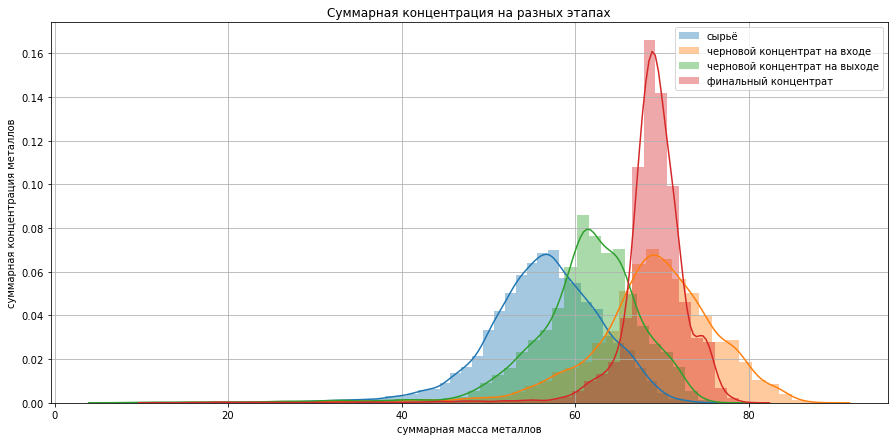

In [10]:
for i in ('rougher.output.concentrate_',
          'primary_cleaner.output.concentrate_',
          'final.output.concentrate_'):
    
    for j in ('au', 'ag', 'pb', 'sol'):
        df_train = df_train[df_train[i+j] >= 1]
    
concentrate_metalls_all_stages()

Также проверим концентрацию металлов на разных этапах очистки после удаления нулевых значений

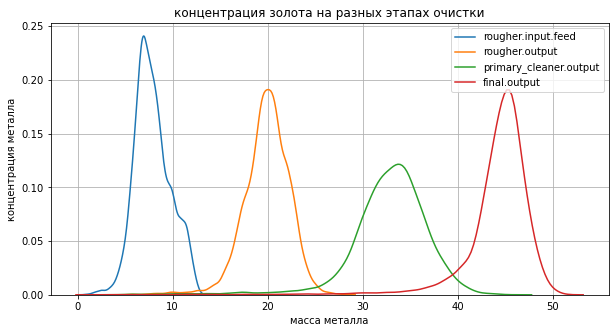

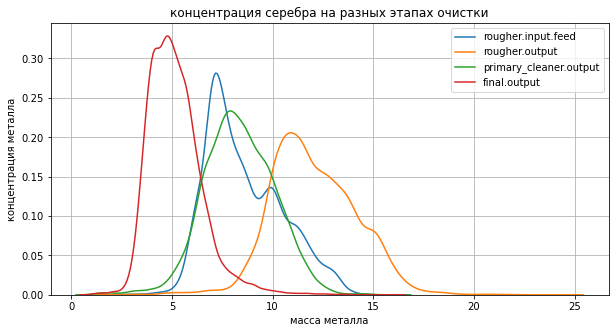

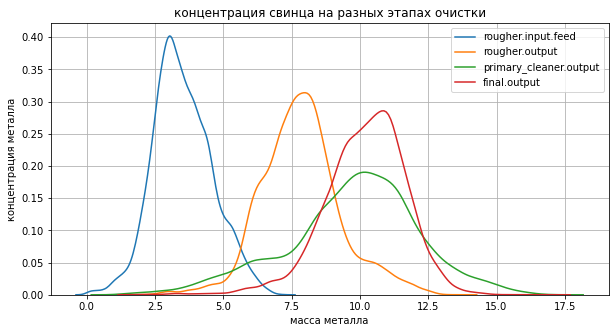

In [11]:
concentrate_stages_metalls()

На новых графиках данные без нулевых значений концентраций метталов, выбросы удалены. Был использован именно distplot для наглядности выбросов в нуле чернового концентрата, для которого выбросы удаляются при значении менее единицы, при неравенстве нулю часть выбросов остается.

### 2.4 Вывод

В ходе анализа данных были проделаны следующие шаги:

- визуализирована динамика концентрации металлов на различных этапах очистки, показано влияние концентраций друг на друга, выявлены аномалии в нулевом диапазоне;
- визуализировано распределение размеров гранул сырья на обучающей и тестовой выборках для определения точности оценки модели - исход положительный;
- исследована суммарная концентрация всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах, подтверждены аномалии в нулевом диапазоне;
- аномалии удалены, данные повторно визуально проверены - исход положительный.

## 3. Моделирование

### 3.1 Напишите функцию для вычисления итоговой sMAPE. 

объявим функцию, у которой на вход подается два датафрейма с таргетами и предсказаниями, преобразуем их в матрицы и сделаем обращение по каждой строке для обоих таргетов в соответствии индексации, на выходе посчитаем итоговую метрику

In [18]:
def sMAPE(y, pred):
    y = y.values
    
    sums = 0    
    for i in range(len(y)):
        sums += abs(y[i, 0] - pred[i, 0]) / (abs(y[i, 0] + pred[i, 0]) / 2)
        sMAPE_rougher = sums/len(y)*100
        
    sums = 0
    for i in range(len(y)):
        sums += abs(y[i, 1] - pred[i, 1]) / (abs(y[i, 1] + pred[i, 1]) / 2)
        sMAPE_final = sums/len(y)*100
    
    return 0.25 * sMAPE_rougher + 0.75 * sMAPE_final

### 3.2 Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы. 

#### 3.2.1 Подготовка к обучнию моделей

- сделаем столбец date столбцом с индексами для изъятия таргетов для теста из полного датасета;
- объявим переменные для признаков и таргетов для rougher и final для подсчета sMAPE;
- масштабируем обучающую выборку;
- заведем sMAPE в созданный скорер;
- заведем скорер в gscv;
- обучим модели на трейне, выведем лучшее значение скорера на каждой

In [19]:
for i in (df_full, df_train, df_test):
    i.set_index(i['date'], drop=True, inplace=True)

In [20]:
X = df_train.drop(diff, axis=1).drop('date', axis=1)

y = df_train[['rougher.output.recovery','final.output.recovery']]

scaler = StandardScaler()
scaler.fit(X) 
X = scaler.transform(X)

print(f'Размер трейна {X.shape}, размер таргетов на трейне {y.shape}')

Размер трейна (13425, 52), размер таргетов на трейне (13425, 2)


In [21]:
scorer = make_scorer(sMAPE, greater_is_better=False)

Объявим функцию, на вход подается моедль и параметры, на выходе лучшая модель после обучения для дальнейшего тестирования

In [38]:
def model_score(model, params):
    
    model_fit = GridSearchCV(
                        model,
                        params,
                        cv = KFold(3, shuffle=True, random_state=RS),
                        n_jobs=-1,
                        scoring=scorer,
                        verbose=10
    )
    model_fit.fit(X, y)
    print('-'*17)
    print(f'Best score {(-1*model_fit.best_score_):.3f}')
    print('-'*17)
    return model_fit.best_estimator_

#### 3.2.2 LinearRegression

In [39]:
%%time
lr_best_model = model_score(LinearRegression(),{})

Fitting 3 folds for each of 1 candidates, totalling 3 fits
-----------------
Best score 7.051
-----------------
CPU times: total: 93.8 ms
Wall time: 287 ms


#### 3.2.3 DecisionTree

In [40]:
%%time
dt_best_model = model_score(
    DecisionTreeRegressor(random_state=RS), 
    {'max_depth':range(10,15)}
)

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 3 folds for each of 5 candidates, totalling 15 fits
-----------------
Best score 6.402
-----------------


#### 3.2.4 RandomForest

In [53]:
%%time
rf_best_model = model_score(
    RandomForestRegressor(random_state=RS), 
    {'max_depth':[10], 'n_estimators':[100]}
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
-----------------
Best score 5.555
-----------------
CPU times: total: 1min 14s
Wall time: 2min 13s


По итогам работы моделей лучший результат показал лес. Далее приведем к рабочему состоянию тест по аналогии с ттрейном и проверим результат. 

Добавлю, что модель дерева склона к переобучению, на глубине 30 скорер достигает нуля, поэтому какой бы она результат не показала, не стоит рассчитывать на ее адекватную работу.

#### 3.2.5 Подготовка тестовой выборки

- подтянем тестовый таргет из полной выборки;
- масштабируем тестовую выборку;
- проверим размерность тестовых выборки и таргета.

In [54]:
X_test = df_test.drop('date',axis=1)
y_test = df_full.loc[df_test.index][['rougher.output.recovery','final.output.recovery']]

X_test = scaler.transform(X_test)

print(f'Размер выборки {X_test.shape}, таргетов {y_test.shape}')

Размер выборки (5290, 52), таргетов (5290, 2)


#### 3.2.6 Итоговая модель. Тест

In [55]:
print(f'Лес {(sMAPE(y_test, rf_best_model.predict(X_test))):.3f}')

Лес 9.714


#### 3.2.7 Дамми на тесте

In [46]:
DR = DummyRegressor()
DR.fit(X, y)
print(f'Dummy predict {(sMAPE(y_test, DR.predict(X_test))):.3f}')

Дамми на тесте 9.764


Значение итоговой метрики модели леса на тестовой выборке оказалось лучше значения констатной модели дамми. Это означает, что модель пригодна для внедрения в работу и ведет себя адекватно

### 3.3 Вывод

В ходе моделирования были проделаны следующие шаги:

- составлена формула расчета итоговой метрики и заложена в функцию;
- подготовлены признаки и таргеты для обучения и предсказаний моделей;
- обучены 3 модели через алгоритм GridSearchCV с заложенной в него функцией итоговой метрики, найдены оптимальные гиперпарметры;
- для каждой модели расчитаны значения итоговой метрики, выбрана с лучшим показателем;
- в выбранной модели расчитан показатель итоговой метрики на основе новых тестовых данных, модель прошла проверку на адекватность и рекомендована к дальнейшей работе и улучшению.

## 4 Вывод по проекту

В ходе проделанной работы были изучены и преобразованы исходные данные, анализированны производственные технологические процессы, исходные материалы и продукты их взаимодействия. На основе полученных результатов были созданы и проверены на качество несколько моделей прогнозирования искомой величины. В ходе опробации моделей был получен положительный результат. Итоговая модель показала хороший результат и адекватное поведение при работе с тестовыми данными. Для дальнейшего внедрения разработанной модели рекомендуется улучшить ее характеристики: дополнительно проверить ее работу на новых данных в пробном периоде для корректировки настроек.